---
format:
  html:
    code-line-numbers: false
    code-overflow: wrap
    code-block-bg: true
    code-block-border-left: true
    highlight-style: arrow
  pdf:
    documentclass: scrreprt
    links-as-notes: true
    reference-location: section
    toc: true
    toc-depth: 2
    lof: true
    lot: true
    number-sections: true
    fig-width: 8
    fig-height: 6

---

# Simulated Annealing for GAP

## Algorithm Design

## Implementation Details


```{.java filename="GapSolution.java" #lst-gap-sol lst-cap="The solution class"}
package com.voyager.opt.metaheuristics.gap;

import lombok.Getter;

import java.util.Arrays;
import java.util.Random;
import java.util.stream.IntStream;

@Getter
public final class GapSolution {
  /**
   * reference to the instance to be solved
   */
  private final GapInstance instance;
  /**
   * dimension: 1 * numTasks
   * assigned agent index for each task
   */
  private final int[] agentAssignments;
  /**
   * dimension: 1 * numAgents
   * consumed capacity of each agent
   */
  private final int[] consumedCapacities;
  /**
   * total objective value
   */
  private int objective;
  /**
   * assignment cost, without penalties
   */
  private int assignmentCost;
  /**
   * capacity violation penalties of all agents
   */
  private int capacityViolationPenalty;

  public GapSolution(GapInstance instance) {
    this.instance = instance;
    this.agentAssignments = new int[this.instance.getNumTasks()];
    this.consumedCapacities = new int[this.instance.getNumAgents()];
    Arrays.fill(this.agentAssignments, 0);
    Arrays.fill(consumedCapacities, 0);
    this.objective = 0;
    this.assignmentCost = 0;
    this.capacityViolationPenalty = 0;
  }

  /**
   * copy constructor
   * @param other the other solution to copy from
   */
  public GapSolution(GapSolution other) {
    this.instance = other.instance;
    this.agentAssignments = new int[this.instance.getNumTasks()];
    System.arraycopy(other.agentAssignments, 0,
      this.agentAssignments, 0,
      this.instance.getNumTasks());
    this.consumedCapacities = new int[this.instance.getNumAgents()];
    System.arraycopy(other.consumedCapacities, 0,
      this.consumedCapacities, 0,
      this.instance.getNumAgents());
    this.objective = other.objective;
    this.assignmentCost = other.assignmentCost;
    this.capacityViolationPenalty = other.capacityViolationPenalty;
  }

  /**
   * randomly assign tasks to agents
   * @param random random number generator
   */
  public void initialize(Random random) {
    int[][] resources = this.instance.getResources();
    for (int i = 0; i < instance.getNumTasks(); i++) {
      int agentIdx = random.nextInt(instance.getNumAgents());
      this.agentAssignments[i] = agentIdx;
      this.consumedCapacities[agentIdx] += resources[agentIdx][i];
    }
  }

  /**
   * compute objective values
   * @param capacityViolationPenalty penalty factor
   */
  public void computeObjective(int capacityViolationPenalty) {
    // compute assignment costs
    this.assignmentCost = IntStream.range(0, instance.getNumTasks())
      .map(taskIdx -> instance.getCosts()[agentAssignments[taskIdx]][taskIdx])
      .sum();

    // compute capacity violation costs
    this.capacityViolationPenalty = IntStream.range(0, instance.getNumAgents())
      .map(agentIdx -> capacityViolationPenalty *
        Math.max(0, this.consumedCapacities[agentIdx] - instance.getCapacities()[agentIdx]))
      .sum();

    this.objective = this.assignmentCost + this.capacityViolationPenalty;
  }

  public int getAssignedAgent(int taskIdx) {
    return this.agentAssignments[taskIdx];
  }

  /**
   * assign agent to task
   * @param taskIdx the task to be assigned
   * @param agentIdx the agent index
   */
  public void setAssignedAgent(int taskIdx, int agentIdx) {
    int currAgentIdx = this.agentAssignments[taskIdx];
    this.agentAssignments[taskIdx] = agentIdx;
    this.consumedCapacities[currAgentIdx] -= instance.getResources()[currAgentIdx][taskIdx];
    this.consumedCapacities[agentIdx] += instance.getResources()[agentIdx][taskIdx];
  }
}
```

```{.java filename="GapSimulatedAnnealing.java" #lst-gap-sa lst-cap="Simulated annealing implementation"}
package com.voyager.opt.metaheuristics.gap.sa;

import com.voyager.opt.metaheuristics.gap.GapInstance;
import com.voyager.opt.metaheuristics.gap.GapInstanceReader;
import com.voyager.opt.metaheuristics.gap.GapSolution;
import com.voyager.opt.metaheuristics.utils.PerfRecord;
import com.voyager.opt.metaheuristics.utils.PerfRecordsWriter;
import lombok.Getter;
import lombok.Setter;

import java.io.File;
import java.io.IOException;
import java.net.URISyntaxException;
import java.util.ArrayList;
import java.util.List;
import java.util.Random;

@Getter
@Setter
public class GapSimulatedAnnealing {
  /**
   * instance to be solved
   */
  private final GapInstance instance;
  /**
   * random number generator
   */
  private final Random random;
  /**
   * best solution
   */
  private GapSolution bestSolution;
  /**
   * performance records
   */
  private List<PerfRecord<Integer>> perfRecords;

  public GapSimulatedAnnealing(GapInstance instance) {
    this.instance = instance;
    this.random = new Random(42);
    this.bestSolution = null;
    this.perfRecords = new ArrayList<>();
  }

  public void solve() {
    // penalty factor for capacity violation
    int capacityViolationPenalty = 1000;
    double initialTemperature = 1000;
    double coolingRate = 0.9999;
    double endingTemperature = 0.0001;
    int iterationsPerTemperature = 100;

    // create a starting solution
    GapSolution currSolution = new GapSolution(this.instance);
    currSolution.initialize(this.random);
    currSolution.computeObjective(capacityViolationPenalty);
    this.bestSolution = currSolution;
    this.perfRecords.add(new PerfRecord<>(0,
      currSolution.getObjective(),
      bestSolution.getObjective()));

    int numTasks = this.instance.getNumTasks();
    int numAgents = this.instance.getNumAgents();

    // Set initial temperature
    double temperature = initialTemperature;

    while (temperature > endingTemperature) {
      System.out.println("temperature: " + temperature +
        ", curr_obj: " + currSolution.getObjective() +
        ", best_obj: " + bestSolution.getObjective());
      for (int i = 0; i < iterationsPerTemperature; i++) {
        // Generate neighbor solution
        GapSolution newSolution = new GapSolution(currSolution);

        // mutate one task assignment
        int randTaskIdx = this.random.nextInt(numTasks);
        int currAgentIdx = newSolution.getAssignedAgent(randTaskIdx);
        int newAgentIdx = this.random.nextInt(numAgents);
        while (newAgentIdx == currAgentIdx) {
          newAgentIdx = this.random.nextInt(numAgents);
        }
        newSolution.setAssignedAgent(randTaskIdx, newAgentIdx);

        // compute objective value after mutation
        newSolution.computeObjective(capacityViolationPenalty);

        // Calculate cost differences
        int deltaCost = newSolution.getObjective() - currSolution.getObjective();

        // Accept or reject neighbor solution based on Metropolis criterion
        if (deltaCost < 0 || Math.exp(-deltaCost / temperature) > random.nextDouble()) {
          currSolution = newSolution;
        }

        // Update best assignment
        if (currSolution.getObjective() < bestSolution.getObjective()) {
          bestSolution = currSolution;
        }
      }

      // Cool down temperature
      temperature *= coolingRate;
    }
  }

  public static void main(String[] args) throws IOException, URISyntaxException {
    File file = new File("src/main/resources/data/gap/gap1.txt");
    String filePath = file.getAbsolutePath();
    String outputFilename = "/Users/klian/dev/books/metaheuristics-java/data/gap/perf_records_sa.csv";
    List<GapInstance> instances = GapInstanceReader.read(filePath);

    GapInstance instance = instances.get(1);
    GapSimulatedAnnealing simulatedAnnealing = new GapSimulatedAnnealing(instance);
    simulatedAnnealing.solve();

    // save performance records
    PerfRecordsWriter.write(outputFilename, simulatedAnnealing.getPerfRecords());
  }
}
```

## Performance Illustration

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/klian/dev/books/metaheuristics-java/data/gap/perf_records_sa.csv", names=['iteration', 'curr_obj', 'best_obj'])
df

,iteration,curr_obj,best_obj
0,0,79294,79294
1,1,15298,14297
2,2,14297,14297
3,3,10292,10292
4,4,10292,10292
...,...,...,...
161168,161168,291,271
161169,161169,291,271
161170,161170,291,271
161171,161171,291,271


(0.0, 80000.0)

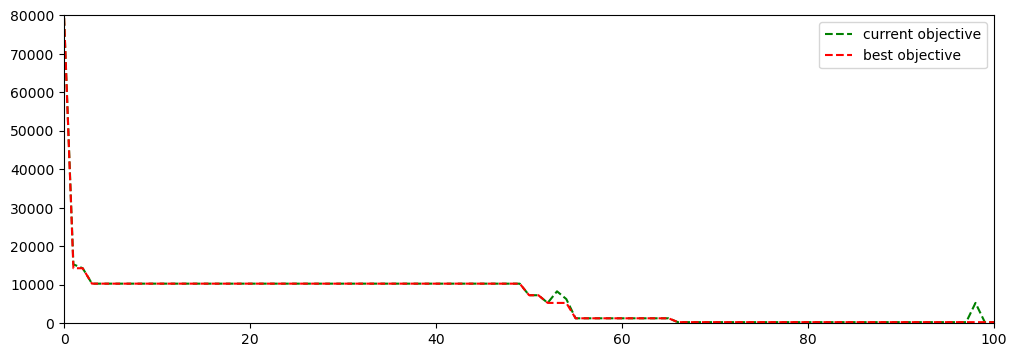

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(df['iteration'], df['curr_obj'], 'g--', label="current objective")
ax.plot(df['iteration'], df['best_obj'], 'r--', label="best objective")
ax.legend()

ax.set_xlim([0, 100])
ax.set_ylim([0, 80000])